In [1]:
# first version of radial profile code
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.io as sio
import numpy as np
import sys as sys
mat_contents = sio.loadmat('onehund.mat') 
lfp = mat_contents["onehund"]
csdx = np.array([[0.003130],[0.003169],[0.004244],[0.003107],[0.004100],[0.005167],[0.002875],[0.003953],[0.004989],[0.006077],[0.003860],[0.004917],[0.005932],[0.004772],[0.005860],[0.005582]])
csdy = np.array([[0.002755],[0.003659],[0.002939],[0.004602],[0.003788],[0.002985],[0.005545],[0.004720],[0.003826],[0.003106],[0.005748],[0.004769],[0.003956],[0.005831],[0.004815],[0.005748]])
print(np.shape(csdx))
print("min x: ",np.min(csdx))
print("max x: ",np.max(csdx))
print("min y: ",np.min(csdy))
print("max y: ",np.max(csdy))
csd_x = np.flipud(csdx)
csd_y = np.flipud(csdy)
csd_at = np.hstack((csd_x,csd_y))
t_max = 0

(16, 1)
min x:  0.002875
max x:  0.006077
min y:  0.002755
max y:  0.005831


In [2]:
print(np.max(lfp))
print(np.min(lfp))
sigma = np.std(lfp)
mu = np.mean(lfp)

1877
-1041


In [3]:
evenind = 2*np.arange(lfp.shape[1]/2).astype(int)
oddind = (2*np.arange(lfp.shape[1]/2)+1).astype(int)
lfpeven = lfp[:,evenind]
lfpodd = lfp[:,oddind]
print(lfpeven.shape)
print(lfpodd.shape)

(16, 68)
(16, 68)


In [4]:
meanodd = np.mean(lfpodd, axis=1)
meaneven = np.mean(lfpeven, axis=1)
stdodd = np.std(lfpodd, axis=1)
stdeven = np.std(lfpeven, axis=1)
print(stdodd)

[274.80804051 258.96676852 295.73099092 276.35015838 301.29780522
 317.56830587 236.47244796 279.96919126 392.6600108  315.17493083
 263.00993804 433.98389932 307.39638414 225.50598432 292.20762455
 216.78136409]


In [5]:
print(oddind.shape[0])
print(meanodd.shape)
print(lfp[1,oddind].shape)

68
(16,)
(68,)


In [6]:
lfp2 = np.zeros((16,136))
for i in range(meanodd.shape[0]):
    lfp2[i,oddind] = (0.1*stdodd[i])*np.random.randn(oddind.shape[0])+meanodd[i]
for i in range(meaneven.shape[0]):
    lfp2[i,evenind] = (0.1*stdeven[i])*np.random.randn(evenind.shape[0])+meaneven[i]
print(lfp2.shape)

(16, 136)


In [7]:
lfp = lfp2

In [8]:
from scipy.interpolate import griddata
start = 0 #1280 #6030; #6030; #4981 #5980 #11500 #5990 #6010;
end = lfp.shape[1];
print(end)
dt = 0.003;
#n = end-start+1
n=lfp.shape[1]-1 #299 #100; #999;  #10;
lfp1=np.reshape(lfp[:,start],(-1,1))
grid_x, grid_y = np.mgrid[0.0031:0.0055:100j,                                                                                                                                                           
                  0.0031:0.0055:100j]

grid_z = griddata(csd_at, lfp1, (grid_x,grid_y),method='cubic') 
for x in range(n):  
    lfp1=np.reshape(lfp[:,start+1+x],(-1,1))  # start+1 because grid_z(:,:,0) already created  
    grid_z = np.dstack((grid_z,griddata(csd_at, lfp1, (grid_x,grid_y),method='cubic'))) #"cubic")))
    t_max_tmp = np.nanmax(np.abs(grid_z[:,:,x]))
    if t_max_tmp > t_max:
        t_max=t_max_tmp
print(t_max)
print(np.shape(grid_x))
print(np.shape(grid_y))
print(np.shape(grid_z))

136
534.1522890182349
(100, 100)
(100, 100)
(100, 100, 136)


In [9]:
cx = (int) (grid_z.shape[0]/2)
cy = (int) (grid_z.shape[1]/2)

In [10]:
import math
import copy
import scipy.signal as scp
lfpmaxangle = []
lfpminangle = []
lfpmaxval = []
lfpminval = []
lfpradprof = []
for num in range(n):
    #Normalization
    img = copy.deepcopy(grid_z[:,:,num])
    #img = img-minval
    #img = img/(maxval-minval)
    #img = img-np.min(img)
    #img = img/(np.max(img)-np.min(img))
    for x in range(grid_z.shape[0]):
        for y in range(grid_z.shape[1]):
            if((x-cx)*(x-cx)+(y-cy)*(y-cy)>2500):
                img[x,y] = 0;
    f = np.fft.fft2(img)
    
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    img = np.rot90(img)
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    img_b = np.rot90(img_back)
    radii = []
    sumradii1 = []
    sumradii2 = []
    for r in range(360):
        width = magnitude_spectrum.shape[0]
        height = magnitude_spectrum.shape[1]
        theta = 2 * math.pi * r / 360;
        dx = (math.cos(theta));
        dy = (math.sin(theta));
        w2 = width * width / 4;
        h2 = height * height / 4;
        m = math.sqrt(w2 * h2 / (dx * dx * h2 + dy * dy * w2));
        x = (cx + m * dx);
        y = (cy + m * dy);
        distance = math.sqrt((x-cx)*(x-cx)+(y-cy)*(y-cy))
        nr = 20;
        radialsum1 = 0;
        radialsum2 = 0;
        for s in range(1,nr):
            sx = (int)(cx + s*distance/nr*dx)
            sy = (int)(cy + s*distance/nr*dy)
            radialsum1 = radialsum1 + grid_z[sx,sy,num];
            radialsum2 = radialsum2 + magnitude_spectrum[sx,sy];
        radii.append(r);
        sumradii1.append(radialsum1);
        sumradii2.append(radialsum2);
    print('Image '+str(num))
    print('Max located at: '+str(radii[np.argmax(sumradii1)])+" degrees, Val: "+str(np.max(sumradii1)))
    print('Min located at: '+str(radii[np.argmin(sumradii1)])+" degrees, Val: "+str(np.min(sumradii1)))
    filtsumrad2 = scp.savgol_filter(sumradii2, 53, 3) #FFT Magnitude Spectrum Filtered
    lfpmaxangle.append(radii[np.argmax(sumradii1)])
    lfpminangle.append(radii[np.argmin(sumradii1)])
    lfpmaxval.append(np.max(sumradii1))
    lfpminval.append(np.min(sumradii1))
    lfpradprof.append(sumradii1)

Image 0
Max located at: 115 degrees, Val: 498.1914608011348
Min located at: 0 degrees, Val: 116.13194063608458
Image 1
Max located at: 260 degrees, Val: 8438.608536200994
Min located at: 126 degrees, Val: 5930.737426153959
Image 2
Max located at: 260 degrees, Val: 1187.3811654907704
Min located at: 42 degrees, Val: 469.8312342761841
Image 3
Max located at: 235 degrees, Val: 8115.839815281748
Min located at: 16 degrees, Val: 6770.328378125914
Image 4
Max located at: 233 degrees, Val: 1293.4836271687645
Min located at: 12 degrees, Val: 272.7415038924287
Image 5
Max located at: 235 degrees, Val: 9197.624100243442
Min located at: 31 degrees, Val: 7104.3567782547
Image 6
Max located at: 125 degrees, Val: 922.0168288299616
Min located at: 22 degrees, Val: 56.25887328718484
Image 7
Max located at: 177 degrees, Val: 8113.280123462974
Min located at: 21 degrees, Val: 6664.222384024309
Image 8
Max located at: 135 degrees, Val: 1296.6046391253242
Min located at: 21 degrees, Val: 265.2509633020712

Image 80
Max located at: 260 degrees, Val: 531.3032812229621
Min located at: 114 degrees, Val: -397.79788976895463
Image 81
Max located at: 263 degrees, Val: 7685.3725298898025
Min located at: 132 degrees, Val: 5563.027226411212
Image 82
Max located at: 245 degrees, Val: 769.1555416534218
Min located at: 24 degrees, Val: 123.21745661456463
Image 83
Max located at: 45 degrees, Val: 8072.577006930929
Min located at: 132 degrees, Val: 6665.044724367474
Image 84
Max located at: 257 degrees, Val: 1420.36964689864
Min located at: 126 degrees, Val: 243.20449395599093
Image 85
Max located at: 83 degrees, Val: 7505.7661553720645
Min located at: 21 degrees, Val: 6672.454688954832
Image 86
Max located at: 257 degrees, Val: 1197.9240768207735
Min located at: 90 degrees, Val: -443.46736905334456
Image 87
Max located at: 325 degrees, Val: 7588.027853644233
Min located at: 138 degrees, Val: 5937.000256243025
Image 88
Max located at: 260 degrees, Val: 1292.9227321769895
Min located at: 106 degrees, Va

In [11]:
# Convert lists to array
lfpmaxangle = np.asarray(lfpmaxangle)
lfpminangle = np.asarray(lfpminangle)
lfpmaxval = np.asarray(lfpmaxval)
lfpminval = np.asarray(lfpminval)
lfpradprof = np.asarray(lfpradprof)

In [12]:
# Correlation of Correlations 
#(i.e. correlation coef for if pre correlation high then is post correlation high)
corrind = []
corrind2 = []
for num in np.arange(n):
    for num2 in np.arange(num+1,n):
        if(num%2==0 and num2%2==0 and num<134 and num2<134):
            corrind.append(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1])
        elif(num%2==1 and num2%2==1):
            corrind2.append(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1])
print(len(corrind))
print(len(corrind2))
print(np.corrcoef(corrind, corrind2))

2211
2211
[[ 1.         -0.02473708]
 [-0.02473708  1.        ]]


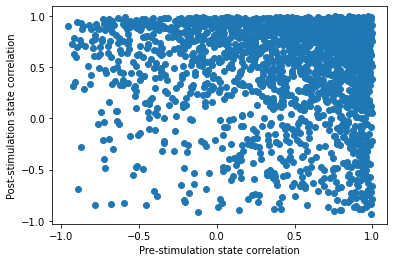

In [13]:
plt.scatter(corrind, corrind2)
plt.rcParams.update({'font.size': 14})
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.xlabel('Pre-stimulation state correlation')
plt.ylabel('Post-stimulation state correlation')
plt.show()

In [14]:
from scipy.stats import linregress
linregress(corrind, corrind2)

LinregressResult(slope=-0.02402873313282729, intercept=0.5283583663802043, rvalue=-0.024737083699976264, pvalue=0.2449555971225431, stderr=0.0206610124539924)

In [15]:
# Correlation of Pre and Post States
corrind3 = []
for num in np.arange(n):
    for num2 in np.arange(n):
        if(num%2==0 and num2%2==0):
            corrind.append(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1])

In [16]:
# Correlation Heatmap
corrind = []
corrind2 = []
for num in np.arange(n):
    for num2 in np.arange(n):
        if(num%2==0 and num2%2==0):
            corrind.append(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1])
        elif(num%2==1 and num2%2==1):
            corrind2.append(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1])

In [17]:
print(n)

135


In [18]:
corrmat = np.asarray(corrind).reshape((int(n/2)+1,int(n/2)+1))
corrmat2 = np.asarray(corrind2).reshape((int(n/2),int(n/2)))

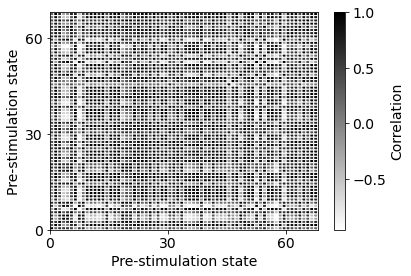

In [19]:
fig, ax = plt.subplots()
im = ax.pcolormesh(corrmat, cmap=cm.binary, edgecolors='white', linewidths=1, antialiased=True)
plt.rcParams.update({'font.size': 14})
plt.xlabel('Pre-stimulation state')
plt.ylabel('Pre-stimulation state')
plt.xticks([0,30,60])
plt.yticks([0,30,60])
#plt.title('Heatmap of Pre-stimulation Radial Profile Correlation')
fig.colorbar(im, label='Correlation')
plt.show()

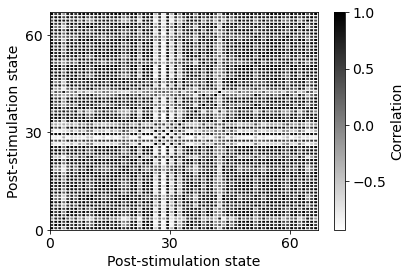

In [20]:
fig, ax = plt.subplots()
im = ax.pcolormesh(corrmat2, cmap=cm.binary, edgecolors='white', linewidths=1, antialiased=True)
fig.colorbar(im, label='Correlation')
#plt.title('Heatmap of Post-stimulation Radial Profile Correlation')
plt.xlabel('Post-stimulation state')
plt.ylabel('Post-stimulation state')
plt.xticks([0,30,60])
plt.yticks([0,30,60])
plt.show()

In [21]:
numpostcorr = 0
contdepmeans = []
contextdependent = []
for num in np.arange(n):
    corr = []
    precorr = []
    print('Image '+str(num))
    for num2 in np.arange(num+1, n):
        if(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1]>0.9 and num%2==num2%2):
            print(str(num2)+': '+str(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1]))
            corr.append(num2)
            if(num<134 and num2<134):
                precorr.append(np.corrcoef(lfpradprof[num+1], lfpradprof[num2+1])[0, 1])
    if(num%2==0):
        if(len(corr)==0):
            contextdependent.append(-1)
        else:
            numpostcorr = numpostcorr+1
            nprecorr = len(np.argwhere(np.asarray(precorr)>0))
            contdepmeans.append(np.mean(precorr))
            contextdependent.append(nprecorr/len(corr))

Image 0
Image 1
17: 0.952900830595164
23: 0.9127617622136484
25: 0.9719426356686103
31: 0.9363354536410816
33: 0.9755927706077879
35: 0.9455863608438089
41: 0.9425276493259744
43: 0.9563081126487165
51: 0.9680272455245551
63: 0.924387562139608
67: 0.9187128795366698
75: 0.9005568751661087
79: 0.9475067141527498
81: 0.9856539678776296
89: 0.9729484264795268
93: 0.9464914412907021
97: 0.9357209153977513
101: 0.9290219013539126
109: 0.9713685234650647
111: 0.9740296077109916
113: 0.9453665344452082
115: 0.9193173669722657
117: 0.9218658600041972
121: 0.9493066207329904
127: 0.9793897050846713
133: 0.9749481453575696
Image 2
20: 0.9403800847463423
22: 0.9316709158198814
26: 0.9642681303256894
32: 0.974330702648073
34: 0.952950860144624
42: 0.9033186669871727
46: 0.9425461151863044
48: 0.9741746857183214
52: 0.9328081065771506
64: 0.9423779035963364
84: 0.902781965704776
86: 0.9462290124354489
88: 0.9067525015786546
94: 0.966770823779468
100: 0.9624729410685032
116: 0.9107423392781735
128: 

115: 0.9724123484996021
121: 0.947206956894311
131: 0.9057658368857218
Image 30
42: 0.9505663091958383
46: 0.9006437671656825
52: 0.9357847067466747
56: 0.9830663498859104
58: 0.9733577901899112
68: 0.9432231010313231
70: 0.9707821134421856
72: 0.9725037574090891
74: 0.9678891571201285
78: 0.9736012211988173
80: 0.9832853114543386
84: 0.9372083105802683
88: 0.918651828255181
102: 0.9706266564051592
112: 0.9908790960490983
132: 0.9423211894744851
Image 31
33: 0.9310175537502071
43: 0.9186520759679351
51: 0.9220507471963678
63: 0.9678153535019794
79: 0.9956649470417909
81: 0.9230382395547229
89: 0.981021911078091
93: 0.9896892865550189
97: 0.9506477123638406
113: 0.9839284214817374
127: 0.9747837170322645
Image 32
34: 0.932012467700183
46: 0.9482305409854296
48: 0.935267977773611
52: 0.9248825924878299
64: 0.9296245456936714
82: 0.9224521906819567
86: 0.9288178469720829
94: 0.9638897631677233
98: 0.9032176592613123
100: 0.9765437399279687
116: 0.9232015076962693
122: 0.9314385040021781
1

99: 0.9604943130006204
101: 0.95911145145318
105: 0.9276611209046456
109: 0.9590004014277028
111: 0.9439034123901694
115: 0.9832295077747645
121: 0.9428734394586077
Image 76
98: 0.9564671228850078
126: 0.9286750101977573
Image 77
83: 0.9118672350862321
103: 0.9607079222228845
Image 78
80: 0.9708934867005528
102: 0.9186113128184975
112: 0.9491413797714507
Image 79
81: 0.9302110554806795
89: 0.9833148870033793
93: 0.9871817387300595
97: 0.9419641409354107
109: 0.9119328007172711
113: 0.9792816790084271
127: 0.9777267763641991
Image 80
84: 0.9136474164882279
86: 0.9226634276007015
88: 0.9559208975812798
102: 0.9746787333593353
110: 0.9430801606462823
112: 0.9860535895937963
132: 0.9632325683848624
Image 81
89: 0.9618709809783834
93: 0.9273167766517308
97: 0.9078003469795456
101: 0.9119166811254685
109: 0.965128452993969
111: 0.964695247440711
113: 0.9132952323260101
117: 0.9404302151655206
121: 0.9317550185497905
127: 0.9672619971996648
133: 0.9579917419416536
Image 82
116: 0.905317127720

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [22]:
numpostcorr = 0
contdepmeans = []
contextdependent = []
for num in np.arange(n):
    corr = []
    precorr = []
    for num2 in np.arange(num+1, n):
        if(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1]>0.9 and num%2==num2%2):
            corr.append(num2)
            if(num>0 and num2>0 and num%2==1):
                precorr.append(np.corrcoef(lfpradprof[num+1], lfpradprof[num2+1])[0, 1])
    if(num%2!=0):
        if(len(corr)==0):
            contextdependent.append(-1)
        else:
            numpostcorr = numpostcorr+1
            nprecorr = len(np.argwhere(np.asarray(precorr)>0))
            contdepmeans.append(np.mean(precorr))
            contextdependent.append(nprecorr/len(corr))

In [23]:
numpostcorr

51

In [24]:
num/2

67.0

In [25]:
contextdependent

[0.9615384615384616,
 0.8333333333333334,
 0.47058823529411764,
 -1,
 0.8888888888888888,
 0.9,
 0.42857142857142855,
 1.0,
 0.8928571428571429,
 0.7142857142857143,
 0.6666666666666666,
 0.9545454545454546,
 0.9565217391304348,
 1.0,
 1.0,
 1.0,
 0.9523809523809523,
 0.7,
 1.0,
 1.0,
 0.9375,
 0.9523809523809523,
 1.0,
 0.8823529411764706,
 1.0,
 1.0,
 1.0,
 -1,
 -1,
 1.0,
 -1,
 0.875,
 -1,
 0.7142857142857143,
 0.625,
 0.8333333333333334,
 -1,
 1.0,
 0.5,
 0.8571428571428571,
 0.8181818181818182,
 0.0,
 -1,
 -1,
 0.36363636363636365,
 -1,
 1.0,
 0.75,
 0.8888888888888888,
 1.0,
 1.0,
 1.0,
 1.0,
 -1,
 1.0,
 1.0,
 1.0,
 1.0,
 0.5,
 -1,
 1.0,
 -1,
 -1,
 1.0,
 -1,
 -1,
 -1]

In [26]:
len(np.argwhere(np.asarray(contextdependent)>0.7))

42

In [27]:
#Repeat but shuffle prestates
shuffledarr = 2*np.arange(n/2).astype(int)
#Permutation
ncdpermutation = []
ncdpermmean = []
for perm in range(1000):
    np.random.shuffle(shuffledarr)
    numpostcorr = 0
    contdepmeans = []
    contextdependent = []
    for num in np.arange(n):
        corr = []
        precorr = []
        for num2 in np.arange(num+1, n):
            if(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1]>0.9 and num%2==num2%2):
                corr.append(num2)
                if(num>0 and num2>0 and num%2==1):
                    precorr.append(np.corrcoef(lfpradprof[shuffledarr[(int)((num-1)/2)]], lfpradprof[shuffledarr[(int)((num2-1)/2)]])[0, 1])
        if(num%2!=0):
            if(len(corr)==0):
                contextdependent.append(-1)
            else:
                numpostcorr = numpostcorr+1
                nprecorr = len(np.argwhere(np.asarray(precorr)>0))
                contdepmeans.append(np.mean(precorr))
                contextdependent.append(nprecorr/len(corr))
    print(perm)
    ncdpermutation.append(len(np.argwhere(np.asarray(contextdependent)>0.7)))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [28]:
print(np.mean(ncdpermutation))

40.066


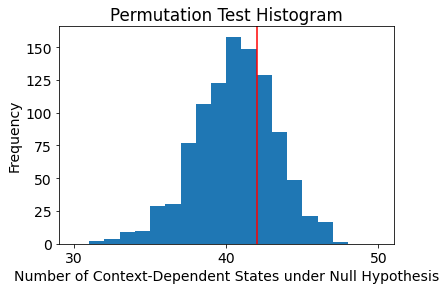

In [34]:
plt.hist(np.asarray(ncdpermutation), bins=20, range=(30,50))
plt.axvline(x=42).set_color('red')
plt.xticks([30,40,50])
plt.title('Permutation Test Histogram')
plt.ylabel('Frequency')
plt.xlabel('Number of Context-Dependent States under Null Hypothesis')
plt.show()

In [30]:
len(np.argwhere(np.asarray(ncdpermutation)>42))

173

In [31]:
np.std(ncdpermutation)

2.6577516814029107